In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import j1

In [2]:
size = 256
D = 0.2        # 20 cm telescope
lam = 550e-9   # 550 nm

y, x = np.indices((size, size))
cx, cy = size // 2, size // 2
r = np.sqrt((x - cx)**2 + (y - cy)**2)
r_norm = r / np.max(r)   # normalize 0 to 1

In [3]:
k = 2 * np.pi / lam
x_arg = (np.pi * D / lam) * (r_norm)

ideal_psf = (2 * j1(x_arg) / x_arg)**2
ideal_psf[x_arg == 0] = 1
ideal_psf = ideal_psf / np.max(ideal_psf)


C:\Users\saipr\AppData\Local\Temp\ipykernel_13032\4263205803.py:4: RuntimeWarning: invalid value encountered in divide
  ideal_psf = (2 * j1(x_arg) / x_arg)**2


In [4]:
defocus_strength = 4       # try 2, 4, 6 to see different levels

phase_defocus = np.exp(1j * defocus_strength * (r_norm**2))

In [5]:
aperture = (r_norm <= 1).astype(float)

pupil_with_defocus = aperture * phase_defocus

In [6]:
psf_defocus = np.abs(np.fft.fftshift(np.fft.fft2(pupil_with_defocus)))**2
psf_defocus /= np.max(psf_defocus)

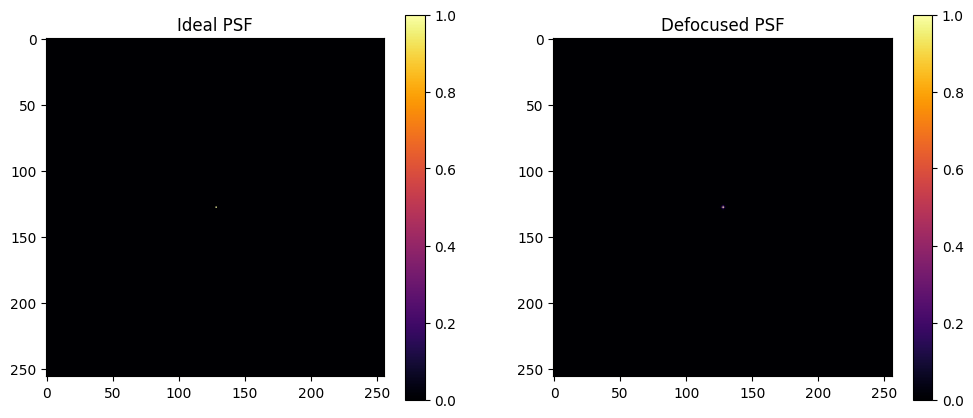

In [7]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.imshow(ideal_psf, cmap='inferno')
plt.title("Ideal PSF")
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(psf_defocus, cmap='inferno')
plt.title("Defocused PSF")
plt.colorbar()

plt.show()

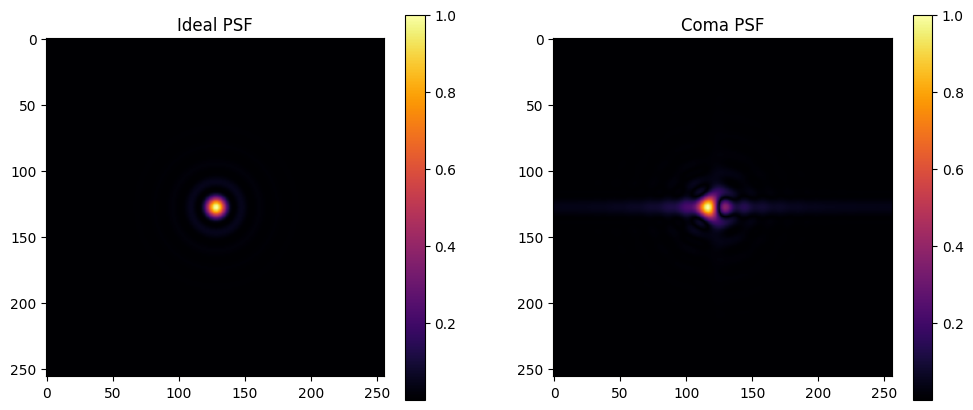

In [8]:
import numpy as np
import matplotlib.pyplot as plt

def airy_psf(size=256, radius=30):
    y, x = np.indices((size, size))
    r = np.sqrt((x - size/2)**2 + (y - size/2)**2)
    x_arg = radius * r / (size/2)
    x_arg[x_arg == 0] = 1e-6
    psf = (2 * np.nan_to_num(np.sin(x_arg)/x_arg))**2
    psf /= psf.max()
    return psf


# ---------- Create Airy PSF ----------
ideal_psf = airy_psf()

# ---------- Generate Coma Wavefront ----------
size = 256
y, x = np.indices((size, size))
cx = x - size/2
cy = y - size/2

# coma strength
coma_strength = 0.0008     # adjust this later

# coma phase term (coma is proportional to x * r)
r = np.sqrt(cx**2 + cy**2)
coma_phase = np.exp(1j * coma_strength * cx * r)

# ---------- Apply to PSF in Fourier domain ----------
fft_psf = np.fft.fft2(ideal_psf)
coma_psf = np.fft.ifft2(fft_psf * coma_phase)
coma_psf = np.abs(coma_psf)
coma_psf /= coma_psf.max()


# ---------- Plot ----------
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(ideal_psf, cmap='inferno')
plt.title("Ideal PSF")
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(coma_psf, cmap='inferno')
plt.title("Coma PSF")
plt.colorbar()

plt.show()

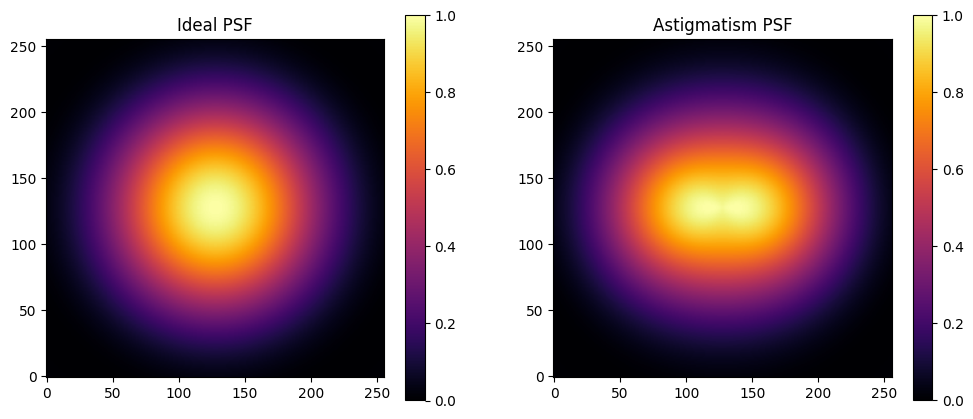

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import j1

# Grid size
N = 256
x = np.linspace(-1, 1, N)
X, Y = np.meshgrid(x, x)
R = np.sqrt(X**2 + Y**2)

# Avoid division issue
eps = 1e-6
r_norm = np.where(R == 0, eps, R)

# ---- Ideal Airy PSF function ----
def airy(r):
    x_val = np.pi * r
    return (2 * j1(x_val) / (x_val + eps))**2

ideal_psf = airy(r_norm)

# ---- Astigmatism term ----
A_ast = 0.2  # strength of astigmatism, you can adjust
theta = np.arctan2(Y, X)
ast_term = 1 + A_ast * np.cos(2 * theta) * r_norm

# Combine
astig_psf = ideal_psf * (ast_term**2)

# Normalize
ideal_psf /= ideal_psf.max()
astig_psf /= astig_psf.max()

# ---- Plot ----
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.imshow(ideal_psf, cmap="inferno", origin="lower")
plt.title("Ideal PSF")
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(astig_psf, cmap="inferno", origin="lower")
plt.title("Astigmatism PSF")
plt.colorbar()

plt.show()

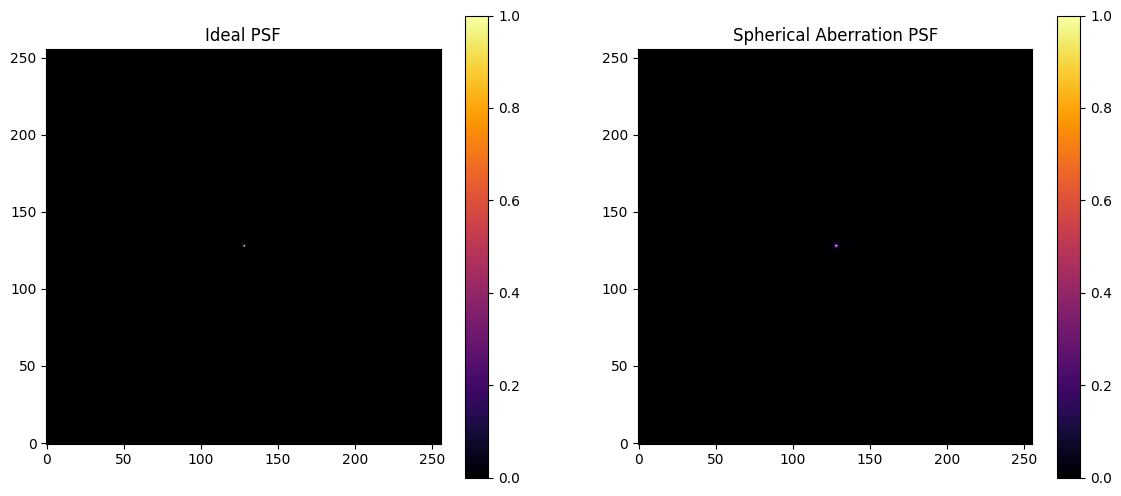

In [10]:
import numpy as np
import matplotlib.pyplot as plt

N = 256
D = 1.0
wavelength = 500e-9

x = np.linspace(-1, 1, N)
X, Y = np.meshgrid(x, x)
R = np.sqrt(X**2 + Y**2)

# Pupil mask
pupil = (R <= 1).astype(float)

# Strength of spherical aberration
SA_strength = 0.5   # you can increase later for stronger effect

# Spherical aberration phase (Zernike term)
phase_spherical = SA_strength * (R**4)

# Wavefront
wavefront = np.exp(1j * 2 * np.pi * phase_spherical)

# Apply pupil
wavefront *= pupil

# PSF from Fourier Transform
psf_spherical = np.abs(np.fft.fftshift(np.fft.fft2(wavefront)))**2
psf_spherical /= psf_spherical.max()

# Ideal PSF (no aberration) for comparison
wavefront_ideal = pupil
psf_ideal = np.abs(np.fft.fftshift(np.fft.fft2(wavefront_ideal)))**2
psf_ideal /= psf_ideal.max()

# Plot
plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
plt.imshow(psf_ideal, cmap='inferno', origin='lower')
plt.title("Ideal PSF")
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(psf_spherical, cmap='inferno', origin='lower')
plt.title("Spherical Aberration PSF")
plt.colorbar()

plt.show()

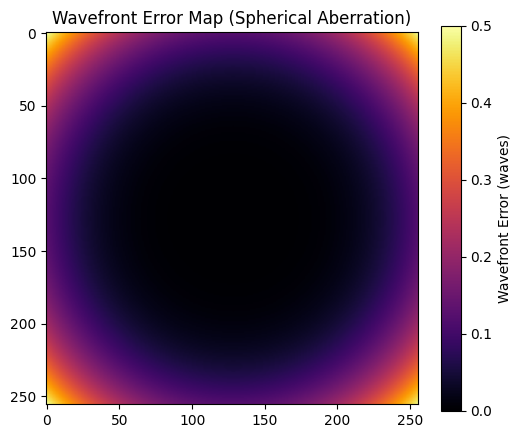

RMS Wavefront Error = 0.11479586617371888 waves
Strehl Ratio = 0.5943718321538634


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import j1

# ---------------------------------------------------
# 1️⃣ WAVEFRONT ERROR MAP (from spherical aberration)
# ---------------------------------------------------

# We reuse the earlier grid and SA term
rho = r / r.max()            # normalize radius to 0–1
W_sa = SA_strength * rho**4  # spherical aberration wavefront

# Plot the wavefront map
plt.figure(figsize=(6,5))
plt.imshow(W_sa, cmap='inferno')
plt.colorbar(label="Wavefront Error (waves)")
plt.title("Wavefront Error Map (Spherical Aberration)")
plt.show()

# ---------------------------------------------------
# 2️⃣ RMS WAVEFRONT ERROR
# ---------------------------------------------------

rms_wfe = np.sqrt(np.mean(W_sa**2))
print("RMS Wavefront Error =", rms_wfe, "waves")

# ---------------------------------------------------
# 3️⃣ STREHL RATIO
# ---------------------------------------------------

strehl = np.exp(-(2 * np.pi * rms_wfe)**2)
print("Strehl Ratio =", strehl)


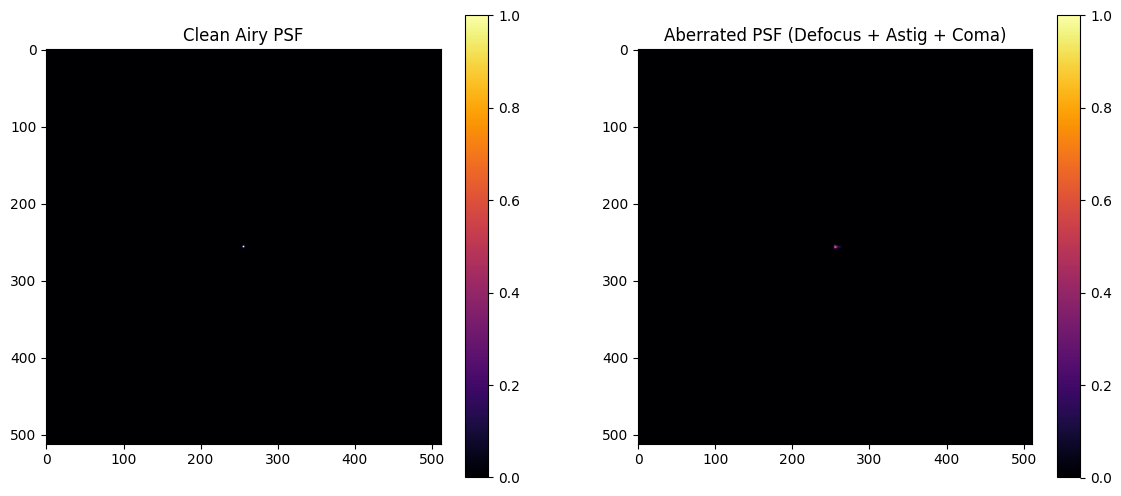

Aberrated PSF created successfully!
Saved psf_zernike.fits


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import j1

# ======================================================
# 1. Base Airy PSF (same as previous notebook)
# ======================================================

def airy_psf(N, wavelength, aperture, pixel_scale):
    x = np.linspace(-N/2, N/2, N) * pixel_scale
    y = np.linspace(-N/2, N/2, N) * pixel_scale
    X, Y = np.meshgrid(x, y)

    R = np.sqrt(X**2 + Y**2)
    k = 2 * np.pi / wavelength
    arg = k * aperture * R

    psf = np.where(arg == 0, 1.0, (2 * j1(arg) / arg)**2)
    return psf / np.max(psf)

# ======================================================
# 2. Wavefront Aberrations (Zernike-based)
# ======================================================

import numpy as np

def zernike_defocus(N, strength):
    y, x = np.indices((N, N))
    x = 2*(x/N - 0.5)
    y = 2*(y/N - 0.5)
    r = np.sqrt(x**2 + y**2)
    r[r > 1] = 0
    return strength * (2*r**2 - 1)

def zernike_astigmatism(N, strength):
    y, x = np.indices((N, N))
    x = 2*(x/N - 0.5)
    y = 2*(y/N - 0.5)
    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)
    r[r > 1] = 0
    return strength * r**2 * np.cos(2*theta)

def zernike_coma(N, strength):
    y, x = np.indices((N, N))
    x = 2*(x/N - 0.5)
    y = 2*(y/N - 0.5)
    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)
    r[r > 1] = 0
    return strength * (r**3 * np.cos(theta))

def zernike_trefoil(N, strength):
    y, x = np.indices((N, N))
    x = 2*(x/N - 0.5)
    y = 2*(y/N - 0.5)
    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)
    r[r > 1] = 0
    return strength * (r**3 * np.cos(3*theta))


# ======================================================
# 3. Create Aberrated PSF
# ======================================================

def aberrated_psf(N, wavelength, aperture, pixel_scale,
                  defocus=0, astig=0, coma=0, trefoil=0):

    base_phase = (
        zernike_defocus(N, defocus) +
        zernike_astigmatism(N, astig) +
        zernike_coma(N, coma) +
        zernike_trefoil(N, trefoil)
    )

    # Complex wavefront
    pupil = np.exp(1j * 2*np.pi * base_phase)

    # Fourier Transform → PSF
    psf = np.abs(np.fft.fftshift(np.fft.fft2(pupil)))**2
    psf /= np.max(psf)
    return psf

# ======================================================
# 4. Generate PSFs and Display
# ======================================================

N = 512
wavelength = 550e-9
aperture = 0.15
pixel_scale = 1e-6

clean = airy_psf(N, wavelength, aperture, pixel_scale)
ab_psf = aberrated_psf(
    N, wavelength, aperture, pixel_scale,
    defocus=0.5,
    astig=0.3,
    coma=0.4,
    trefoil=0.2
)

plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
plt.imshow(clean, cmap="inferno")
plt.title("Clean Airy PSF")
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(ab_psf, cmap="inferno")
plt.title("Aberrated PSF (Defocus + Astig + Coma)")
plt.colorbar()

plt.show()

print("Aberrated PSF created successfully!")

from astropy.io import fits
fits.writeto("psf_zernike.fits", ab_psf.astype(np.float32), overwrite=True)
print("Saved psf_zernike.fits")